# Pytorch VS Pytorch Lightning

The following tutorial aims to show the difference between Pytorch and Pytorch Lightning, comparing what lightning does under the hood to simplify the training process. The Notebook contains following sections: 

- Generate Data 
- Native Pytorch implementation 
- Pytorch Lightning training: Implement training in pytorch lightning 
---

In [2]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from typing import List
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning import Trainer

## Generate Data 
### 🧪 Synthetic Polynomial Regression Dataset (PyTorch)

This synthetic dataset is generated using a **nonlinear polynomial function** with two input features (`x1`, `x2`) and a scalar target `y`. It is ideal for demonstrating regression model training, and nonlinear pattern learning using PyTorch and PyTorch Lightning.

---

### 📐 Data Generation Formula

The target variable `y` is generated using the following equation:

The equation for \(y\) is given by:
$$
y = 10x_{1}^{2} + 5x_{2}^{2} + 2x_{1}x_{2} + 3x_{1} + 4x_{2} + \varepsilon
$$

Where the variables are distributed as follows:
- $x_1$ follows a continuous uniform distribution between -10 and 10, denoted as $x_{1} \sim \mathcal{U}(-10, 10)$.
- $ x_{2}$ follows a continuous uniform distribution between 0 and 5, denoted as $x_{2} \sim \mathcal{U}(0, 5)$.
- $\varepsilon$ represents Gaussian noise with a mean of 0 and a variance of $2^{2} = 4$, denoted as $\varepsilon \sim \mathcal{N}(0, 2^{2})$.

---

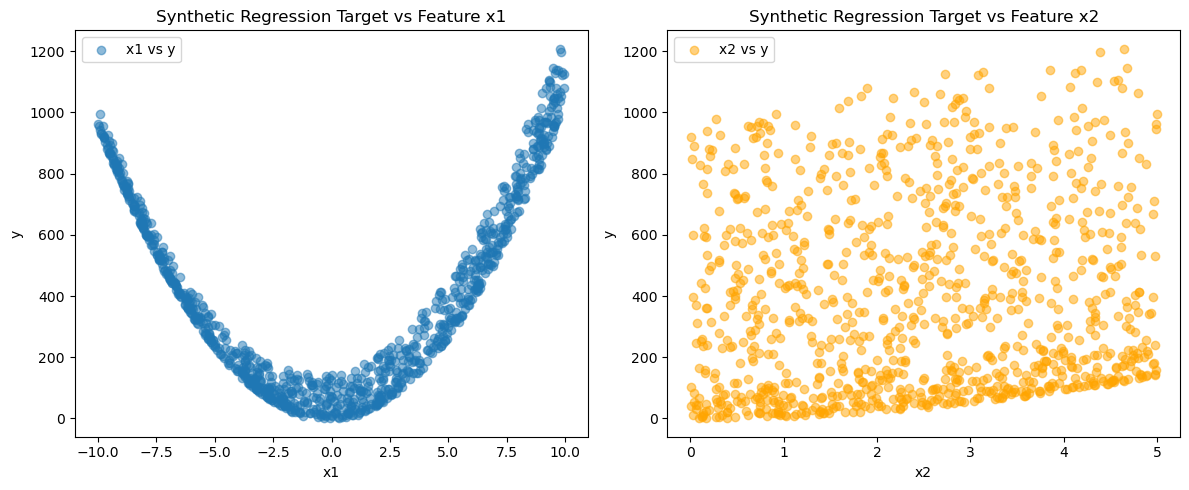

In [3]:
n_samples = 1000
# setting the global seed for pytorch 
torch.manual_seed(99)
# Setting a custom seed for the random number generator
generator = torch.Generator().manual_seed(99)
# Creating uniform random numbers for x1 and x2
x1 = torch.empty(n_samples, dtype=torch.float32).uniform_(-10,10,generator=generator)
x2 = torch.empty(n_samples, dtype = torch.float32).uniform_(0,5,generator=generator)

# Generating the noise 
noise = torch.normal(mean=0, std=2, size=(n_samples,), generator=generator)
# Creating the target variable polynomial 
y = 10 * x1**2 + 5 * x2**2 + 2 * x1 * x2 + 3*x1 + 4*x2 +noise
# vertical stacking to create the input traning data  
X = torch.stack([x1, x2], dim=1)
# creating the target 
y = y.view(-1, 1)
# Plotting data (moved before the split for clarity)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(X[:, 0].numpy(), y.numpy(), alpha=0.5, label="x1 vs y")
plt.xlabel("x1")
plt.ylabel("y")
plt.legend()
plt.title("Synthetic Regression Target vs Feature x1")

plt.subplot(1, 2, 2)
plt.scatter(X[:, 1].numpy(), y.numpy(), alpha=0.5, label="x2 vs y", color='orange')
plt.xlabel("x2")
plt.ylabel("y")
plt.legend()
plt.title("Synthetic Regression Target vs Feature x2")
plt.tight_layout()
plt.show()


---
## Native Pytorch implementation 



In this section, we will implement the training process in Native Pytorch. The training process includes the following steps 

- Define the model 
- Initialize the loss function for the use case
- Select an Optimizer to for learning the paramters 
- Define the scheduler 
- Initialize the dataloaders 
- Design the training loop 


In [4]:
# define the model 

class PolynomialRegressionNNForwardActivation(nn.Module):
    """
    A PyTorch Multi-Layer Perceptron (MLP) model for polynomial regression
    with activation functions defined in the forward method.

    This model takes a single input feature and predicts a single output
    by learning a non-linear mapping through user-defined hidden layers.
    It can approximate polynomial relationships of varying degrees.
    """
    def __init__(self, input_size:int=1, hidden_layers:List[int]=[10], output_size : int=1):
        """
        Initializes the PolynomialRegressionNNForwardActivation model.

        Args:
            input_size (int): The number of input features (typically 1 for simple
                              polynomial regression). Defaults to 1.
            hidden_layers (list of int): A list defining the number of neurons
                                         in each hidden layer. For example,
                                         `[10, 20, 15]` would create three hidden
                                         layers with 10, 20, and 15 neurons, respectively.
                                         Defaults to `[10]` (one hidden layer with 10 neurons).
            output_size (int): The number of output features (typically 1 for
                               polynomial regression). Defaults to 1.
        """
        super(PolynomialRegressionNNForwardActivation, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_layers_config = hidden_layers
        self.linear_layers = nn.ModuleList()
        self.relu = nn.ReLU()

        # Input layer to first hidden layer
        self.linear_layers.append(nn.Linear(self.input_size, self.hidden_layers_config[0]))

        # Hidden layers
        for i in range(len(self.hidden_layers_config) - 1):
            self.linear_layers.append(nn.Linear(self.hidden_layers_config[i], self.hidden_layers_config[i+1]))

        # Output layer
        if self.hidden_layers_config:
            self.linear_layers.append(nn.Linear(self.hidden_layers_config[-1], self.output_size))
        else:
            self.linear_layers.append(nn.Linear(self.input_size, self.output_size)) # No hidden layers

    def forward(self, x:torch.Tensor):
        """
        Performs the forward pass of the polynomial regression MLP
        with activation functions applied directly in this method.

        Args:
            x (torch.Tensor): The input tensor of shape (batch_size, input_size).

        Returns:
            torch.Tensor: The output tensor of shape (batch_size, output_size).
        """
        x = self.linear_layers[0](x)
        x = self.relu(x)

        for i in range(1, len(self.linear_layers) - 1):
            x = self.linear_layers[i](x)
            x = self.relu(x)

        # Output layer (no activation typically for regression)
        x = self.linear_layers[-1](x)
        return x

In [5]:
# intialize the model
model = PolynomialRegressionNNForwardActivation(input_size=2, hidden_layers=[10,20,10], output_size=1)

# Print the model parameters
print(model)
print('*'*100)

# intialize the loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# define the scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)
# set the batch size
batch_size = 32
# train test split 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
# define the dataloader 

train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


PolynomialRegressionNNForwardActivation(
  (linear_layers): ModuleList(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=20, bias=True)
    (2): Linear(in_features=20, out_features=10, bias=True)
    (3): Linear(in_features=10, out_features=1, bias=True)
  )
  (relu): ReLU()
)
****************************************************************************************************


In [6]:
# set the number of epochs
n_epochs = 200

# set the loss history
loss_history = []

# implement the training loop
for epoch in range(n_epochs):
    for batch_X, batch_y in train_dataloader:
        # Forward pass
        y_pred = model(batch_X)
        # Compute the loss
        loss = loss_fn(y_pred, batch_y)
        # Backward pass and optimization
        # Zero the gradients
        optimizer.zero_grad()
        # Compute gradients
        loss.backward()
        # Update the weights
        optimizer.step()
    # Step the scheduler
    scheduler.step()
    # Store the loss
    loss_history.append(loss.item())
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{n_epochs}], Loss: {loss.item():.4f}')

Epoch [10/200], Loss: 11334.4023
Epoch [20/200], Loss: 3265.8408
Epoch [30/200], Loss: 293.0045
Epoch [40/200], Loss: 361.7896
Epoch [50/200], Loss: 111.3836
Epoch [60/200], Loss: 100.2790
Epoch [70/200], Loss: 66.7511
Epoch [80/200], Loss: 186.2331
Epoch [90/200], Loss: 82.8244
Epoch [100/200], Loss: 95.1980
Epoch [110/200], Loss: 29.8833
Epoch [120/200], Loss: 54.2339
Epoch [130/200], Loss: 87.6428
Epoch [140/200], Loss: 50.9995
Epoch [150/200], Loss: 88.6594
Epoch [160/200], Loss: 48.8685
Epoch [170/200], Loss: 32.9459
Epoch [180/200], Loss: 63.4353
Epoch [190/200], Loss: 70.4818
Epoch [200/200], Loss: 33.1957


Test Loss: 48.4635


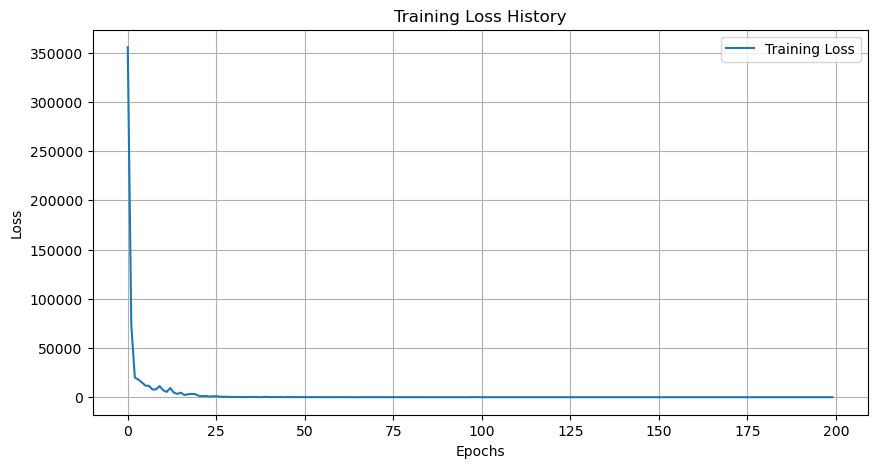

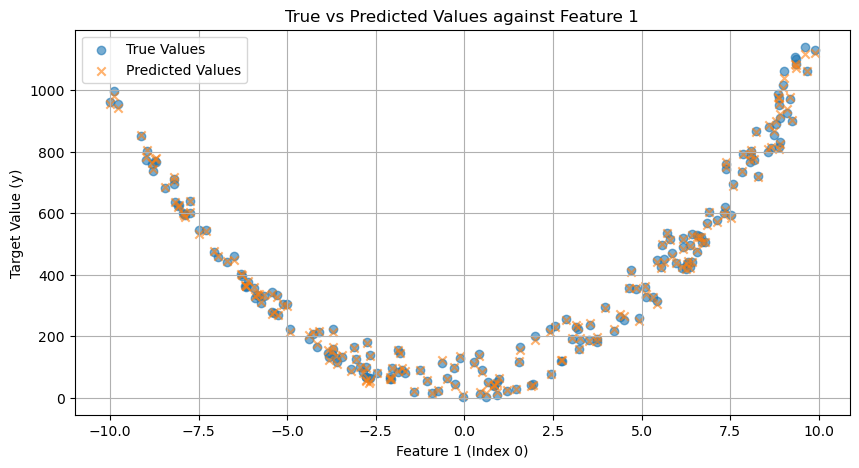

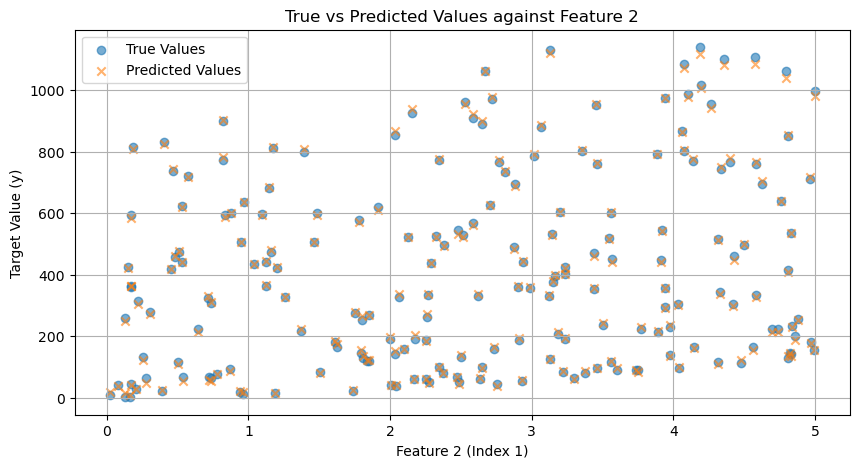

In [7]:
# compute the test loss
with torch.no_grad():
    y_test_pred = model(X_test)
    test_loss = loss_fn(y_test_pred, y_test)
    print(f'Test Loss: {test_loss.item():.4f}')

def to_numpy(data):
    """Converts a PyTorch tensor to a NumPy array if it isn't already."""
    if isinstance(data, torch.Tensor):
        # Ensure tensor is on CPU and detach it from computation graph
        return data.detach().cpu().numpy()
    elif isinstance(data, np.ndarray):
        return data
    else:
        # Try converting lists/tuples, raise error for others
        try:
            return np.array(data)
        except Exception as e:
            raise TypeError(f"Input data must be a PyTorch Tensor, NumPy array, or convertible sequence. Got {type(data)}") from e

def plot_regression_results(
    loss_history: list | np.ndarray | torch.Tensor,
    X_test: np.ndarray | torch.Tensor,
    y_test: np.ndarray | torch.Tensor,
    y_test_pred: np.ndarray | torch.Tensor,
    feature_indices_to_plot: list[int] = [0, 1],
    figsize: tuple[int, int] = (10, 5)
):
    """
    Generates plots for visualizing regression model performance.

    Includes:
    1. Training loss history over epochs.
    2. Scatter plot of true vs. predicted values against specified features.

    Args:
        loss_history: A list, NumPy array, or Tensor containing the loss
                      value for each training epoch.
        X_test: The input features for the test set (NumPy array or Tensor).
                Shape should be (n_samples, n_features).
        y_test: The true target values for the test set (NumPy array or Tensor).
                Shape should be (n_samples,) or (n_samples, 1).
        y_test_pred: The predicted target values for the test set (NumPy array or Tensor).
                     Shape should match y_test.
        feature_indices_to_plot: A list of integer indices corresponding to the columns
                                 (features) in X_test to plot against y.
                                 Defaults to [0, 1].
        figsize: The size of the plot figures (width, height).
    """
    # --- Convert data to NumPy arrays ---
    loss_history_np = to_numpy(loss_history)
    X_test_np = to_numpy(X_test)
    y_test_np = to_numpy(y_test).squeeze() # Use squeeze to handle (n, 1) shape
    y_test_pred_np = to_numpy(y_test_pred).squeeze()

    # --- Input Validation ---
    if y_test_np.shape != y_test_pred_np.shape:
        raise ValueError(f"Shape mismatch: y_test {y_test_np.shape} and y_test_pred {y_test_pred_np.shape} must have the same shape.")
    if X_test_np.shape[0] != y_test_np.shape[0]:
        raise ValueError(f"Sample count mismatch: X_test has {X_test_np.shape[0]} samples, but y_test has {y_test_np.shape[0]} samples.")
    if not loss_history_np.size > 0 :
         raise ValueError("loss_history cannot be empty.")


    # --- Plot 1: Loss History ---
    plt.figure(figsize=figsize)
    plt.plot(loss_history_np, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss History')
    plt.legend()
    plt.grid(True)
    plt.show()

    # --- Plot 2: True vs. Predicted Values against specified features ---
    num_features = X_test_np.shape[1]
    valid_indices = [idx for idx in feature_indices_to_plot if 0 <= idx < num_features]

    if not valid_indices:
         print(f"Warning: No valid feature indices provided or found within the range [0, {num_features-1}]. Skipping feature plots.")
         return # Exit if no valid features to plot

    if len(valid_indices) < len(feature_indices_to_plot):
        print(f"Warning: Some provided feature indices were out of bounds (valid range [0, {num_features-1}]). Plotting only valid indices: {valid_indices}")


    for i, feature_idx in enumerate(valid_indices):
        plt.figure(figsize=figsize)
        plt.scatter(X_test_np[:, feature_idx], y_test_np, label='True Values', alpha=0.6)
        plt.scatter(X_test_np[:, feature_idx], y_test_pred_np, label='Predicted Values', alpha=0.6, marker='x') # Different marker
        plt.xlabel(f'Feature {feature_idx+1} (Index {feature_idx})') # More descriptive label
        plt.ylabel('Target Value (y)')
        plt.title(f'True vs Predicted Values against Feature {feature_idx+1}')
        plt.legend()
        plt.grid(True)
        plt.show()


plot_regression_results(
    loss_history=loss_history,
    X_test=X_test,
    y_test=y_test,
    y_test_pred=y_test_pred,
    feature_indices_to_plot=[0, 1] # Plot against first two features
)




## Pytorch Lightning Implementation 

let us all implement a training process in pytorch lightning. The training process on an high level involves listed below steps such as: 

- Define a Lightning Module 
- Instantiate a lightning data module 
- Define a pytorch lightning trainer

---
### **Understanding the [`DataModule`](https://lightning.ai/docs/pytorch/stable/data/datamodule.html#lightningdatamodule)**

In PyTorch Lightning, the `LightningDataModule` is a convenient way to organize all your data-related steps: loading, splitting, transforming, and creating DataLoaders. It helps keep your data code separate from your model code (`LightningModule`), making your project cleaner and more reproducible.

Let's break down the simple `DataModule` provided for our synthetic regression task.

#### **Breakdown of the `DataModule`**

1.  **Class Definition (`class DataModule(LightningDataModule):`)**
    * Our class `DataModule` inherits from `pytorch_lightning.LightningDataModule`. This gives it the standard structure expected by the PyTorch Lightning `Trainer`.

2.  **`__init__(self, X, y, batch_size=32)`**
    * **Purpose**: The constructor. It's called when you create an instance of the `DataModule`.

3.  **`setup(self, stage=None)`**
    * **Purpose**: This method contains the logic for splitting the data. Crucially, PyTorch Lightning ensures this method is called *automatically* before training (`stage='fit'`) or testing (`stage='test'`). It's designed to handle data preparation steps that should happen on each process in distributed training scenarios.

4.  **`train_dataloader(self)`**
    * **Purpose**: To provide the `DataLoader` for the training phase. The PyTorch Lightning `Trainer` will automatically call this method when training starts (`trainer.fit(...)`).

5.  **`test_dataloader(self)`**
    * **Purpose**: To provide the `DataLoader` for the testing phase. The `Trainer` calls this when you run `trainer.test(...)`.

#### **Why Use a `DataModule`?**

* **Organization**: Keeps all data-related logic in one place, such as data loading, downloads transformations etc. 
* **Reusability**: Easily reuse the same data setup for different models.
* **Sharing & Reproducibility**: Simplifies sharing data pipelines.
* **Lightning Integration**: Works seamlessly with the `Trainer`'s lifecycle hooks (`setup`, automatic calls to `*_dataloader`).
* **Distributed Training**: Handles complexities of data splitting and loading across multiple GPUs/nodes correctly.

In [8]:
class DataModule(pl.LightningDataModule):
    """
    DataModule for a simple synthetic regression tutorial.

    This class handles:
      1. Receiving feature/target tensors
      2. Splitting into train and test sets
      3. Exposing train and test DataLoaders
    
    Note:
      - We use an 80/20 split here for demonstration.
      - A full industrial pipeline would also include a validation split,
        transforms, and a prepare_data() hook, but those are out of scope.
    """

    def __init__(self, X: torch.Tensor, y: torch.Tensor, batch_size: int = 32):
        """
        Initialize with raw data and hyperparameters.

        Args:
            X (torch.Tensor): Feature matrix of shape (n_samples, n_features).
            y (torch.Tensor): Target vector of shape (n_samples, 1).
            batch_size (int): Mini-batch size for training and testing.
        """
        super().__init__()
        # Store the full dataset in-memory
        self.X = X
        self.y = y
        # Store batch size for DataLoaders
        self.batch_size = batch_size

    def setup(self, stage: str = None):
        """
        Split data into training and test sets.

        This is called on every GPU/process. The `stage` arg can be
        used to create different splits for 'fit', 'validate', 'test', etc.
        Here we only need one split for both training and testing.

        Args:
            stage (str, optional): Either 'fit', 'test', or None.
        """
        # 80% train / 20% test split with a fixed random seed
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X,
            self.y,
            test_size=0.2,
            random_state=42  # ensures reproducible splits
        )

    def train_dataloader(self) -> DataLoader:
        """
        Return a DataLoader for the training data.

        Returns:
            DataLoader: Shuffled loader over (X_train, y_train).
        """
        train_ds = TensorDataset(self.X_train, self.y_train)
        return DataLoader(
            train_ds,
            batch_size=self.batch_size,
            shuffle=True,      # shuffle for each epoch
            # num_workers=4,   # uncomment for faster loading in real projects
            # pin_memory=True, # uncomment when using GPU
        )

    def test_dataloader(self) -> DataLoader:
        """
        Return a DataLoader for the test data.

        Returns:
            DataLoader: Sequential loader over (X_test, y_test).
        """
        test_ds = TensorDataset(self.X_test, self.y_test)
        return DataLoader(
            test_ds,
            batch_size=self.batch_size,
            shuffle=False      # no shuffle for consistent evaluation
        )

---

### **Understanding the [`LightningModule`](https://lightning.ai/docs/pytorch/stable/common/lightning_module.html)**

In PyTorch Lightning, the `LightningModule` is the core component where you define your neural network model, how it processes data (`forward` pass), what happens during training (`training_step`), how to optimize it (`configure_optimizers`), and any other logic related to the model's lifecycle and evaluation. It organizes your model code cleanly, separating it from data handling (`LightningDataModule`) and the training orchestration (`Trainer`).

Let's break down the `PolynomialRegressionLightningModule` provided.

#### **Breakdown of the `PolynomialRegressionLightningModule`**

1.  **`__init__(self, input_size, hidden_layers, output_size, lr)`**
    * **Purpose:** The constructor. It's called when you create an instance of the model (`model = PolynomialRegressionLightningModule(...)`). It sets up the fundamental building blocks:
        * Initializes the network layers (`nn.Linear`, `nn.ReLU`) based on the specified `input_size`, `hidden_layers`, and `output_size`.
        * Defines the loss function (`nn.MSELoss`) used to measure prediction error.
        * Initializes an internal dictionary (`self.training_history`) to store metrics like epoch loss later.
        * Saves hyperparameters (`self.save_hyperparameters()`) like the learning rate (`lr`) for tracking and reproducibility.

2.  **`forward(self, x)`**
    * **Purpose:** Defines the "forward pass" – how input data `x` travels through the network's layers to produce an output (prediction). It applies the linear transformations and activation functions sequentially.

3.  **`training_step(self, batch)`**
    * **Purpose:** Defines the sequence of operations for *one single batch* of training data. This is the heart of the learning process within an epoch. It performs these actions:
        * Receives a batch of input features (`x`) and corresponding true target values (`y`).
        * Makes a prediction using the `forward` method (`y_pred = self(x)`).
        * Calculates the error (loss) between the predictions and the true values using the defined `loss_fn`.
        * Logs the calculated batch loss using `self.log("train_loss", ...)`. PyTorch Lightning uses this for progress tracking and automatic averaging over the epoch.
        * Returns the calculated loss value, which the `Trainer` uses to update the model's weights.

4.  **`on_train_epoch_end(self)`**
    * **Purpose:** This is a "hook" automatically called by the `Trainer` *after* the model has processed all training batches for one full epoch. Its job here is specifically:
        * To retrieve the *average* training loss for the epoch that just finished (which `self.log` in `training_step` helps compute).
        * To store this average epoch loss value in the internal `self.training_history` dictionary, allowing us to track performance directly within the model object.

5.  **`test_step(self, batch)`**
    * **Purpose:** Defines the operations for *one single batch* of *testing* data (data not used during training). Similar to `training_step`, it calculates predictions and loss but is used purely for evaluating the model's final performance. It logs the `test_loss`.

6.  **`configure_optimizers(self)`**
    * **Purpose:** Tells the PyTorch Lightning `Trainer` *how* the model's parameters should be updated based on the calculated loss.
        * It sets up the `optimizer` (e.g., Adam), which implements the algorithm for adjusting model weights.
        * It can optionally set up a `lr_scheduler` (learning rate scheduler) to adjust the learning rate during training, potentially helping convergence.

#### **Why Use a `LightningModule`?**

* **Organization:** Keeps all model-related logic (architecture, forward pass, training/validation/test steps, optimizer setup) encapsulated in one class.
* **Reduced Boilerplate:** Automates the training loop, device handling (CPU/GPU/TPU), and other repetitive tasks, letting you focus on the model logic. Works seamlessly with the `Trainer`.
* **Flexibility & Hooks:** Provides numerous hooks (like `on_train_epoch_end`, `on_fit_start`, etc.) to inject custom logic at various points in the training lifecycle.
* **Integrated Logging:** `self.log(...)` provides a simple and powerful way to track metrics using various logger backends (TensorBoard, CSV, etc.) with minimal setup.
* **Reproducibility:** Encourages best practices like hyperparameter saving (`save_hyperparameters`) for easier experiment tracking and replication.

In [9]:
class PolynomialRegressionLightningModule(pl.LightningModule):
    """
    A PyTorch Lightning Module for polynomial regression using a Multi-Layer Perceptron (MLP),
    now storing training loss history internally.
    """

    def __init__(self, input_size: int = 1, hidden_layers: List[int] = [10], output_size: int = 1, lr: float = 0.01):
        """
        Initializes the Lightning Module.

        Args:
            input_size (int): Number of input features.
            hidden_layers (List[int]): List of hidden layer sizes.
            output_size (int): Number of output features.
            lr (float): Learning rate for the optimizer.
        """
        super().__init__()
        self.save_hyperparameters() # Saves args like lr to self.hparams

        # Define the model architecture
        self.linear_layers = nn.ModuleList()
        self.relu = nn.ReLU()

        # Input layer to first hidden layer
        current_dim = input_size
        if hidden_layers: # Check if hidden_layers list is not empty
             self.linear_layers.append(nn.Linear(current_dim, hidden_layers[0]))
             current_dim = hidden_layers[0]
             # Hidden layers
             for i in range(len(hidden_layers) - 1):
                 self.linear_layers.append(nn.Linear(hidden_layers[i], hidden_layers[i + 1]))
                 current_dim = hidden_layers[i+1]
             # Output layer
             self.linear_layers.append(nn.Linear(current_dim, output_size))
        else: # Handle case with no hidden layers (direct input to output)
            self.linear_layers.append(nn.Linear(input_size, output_size))


        # Loss function
        self.loss_fn = nn.MSELoss()

        # Initialize dictionary to store history 
        self.training_history = {'train_loss_epoch': []}
        

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the model. Handles no hidden layers case.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor.
        """
        if not self.linear_layers: # Should not happen with corrected init, but safe check
             return x
        # Apply activation to all but the last layer
        for layer in self.linear_layers[:-1]:
            x = self.relu(layer(x))
        # No activation for the final regression output layer
        x = self.linear_layers[-1](x)
        return x

    def training_step(self, batch):
        """
        Training step for a single batch.

        Args:
            batch: A tuple of (inputs, targets).

        Returns:
            torch.Tensor: Training loss for the batch.
        """
        x, y = batch
        y_pred = self(x)
        loss = self.loss_fn(y_pred, y)

        # Log the training loss.
        # By default, on_step=False, on_epoch=True for training_step
        # This means Lightning will automatically average this over the epoch.
        # prog_bar=True to see in progress bar
        self.log("train_loss", loss, logger=True, prog_bar=True)

        return loss 

    # sample Logger for epoch
    def on_train_epoch_end(self):
        """
        Called at the end of the training epoch.
        Retrieves the logged epoch average training loss and stores it.
        """
        # Access logged metrics for the epoch that just finished
        # PTL automatically creates epoch-averaged keys like 'train_loss_epoch'
        # Use .get() for safety in case the key isn't found (e.g., during sanity checks)
        epoch_loss = self.trainer.logged_metrics.get('train_loss', None)

        if epoch_loss is not None:
            # Ensure we store a standard Python float, not a Tensor
            loss_value = epoch_loss.item() if isinstance(epoch_loss, torch.Tensor) else float(epoch_loss)
            self.training_history['train_loss_epoch'].append(loss_value)
    def test_step(self, batch):
        """
        Test step for a single batch.

        Args:
            batch: A tuple of (inputs, targets).
        Returns:
            None
        """
        x, y = batch
        y_pred = self(x)
        loss = self.loss_fn(y_pred, y)
        # Logs the average test loss at the end of the test phase
        self.log("test_loss", loss, logger=True)

    def configure_optimizers(self):
        """
        Configures the optimizer and learning rate scheduler.

        Returns:
            dict: Optimizer and scheduler configuration.
        """
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)
        return {"optimizer": optimizer, "lr_scheduler": scheduler}


In [10]:
# instantiate the model
model = PolynomialRegressionLightningModule(input_size=2, hidden_layers=[10, 20, 10], output_size=1, lr=0.01)
# instantiate the DataModule
data_module = DataModule(X, y, batch_size=32)
# instantiate the trainer
# Note: You can set gpus=1 if you have a GPU available
trainer = Trainer(max_epochs=100)
# fit the model
trainer.fit(model, datamodule=data_module)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/ramsuryayenda/miniforge3/envs/lightning_course/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | linear_layers | ModuleList | 471    | train
1 | relu 

Epoch 99: 100%|██████████| 25/25 [00:00<00:00, 223.33it/s, v_num=0, train_loss=46.10]  

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 25/25 [00:00<00:00, 211.58it/s, v_num=0, train_loss=46.10]


In [11]:
# test the loss 
trainer.test(model, datamodule=data_module)
# predict the test set observation 
y_test_pred = model(data_module.X_test)


/Users/ramsuryayenda/miniforge3/envs/lightning_course/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing DataLoader 0:   0%|          | 0/7 [00:00<?, ?it/s]

Testing DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 16.42it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            54.90935134887695
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


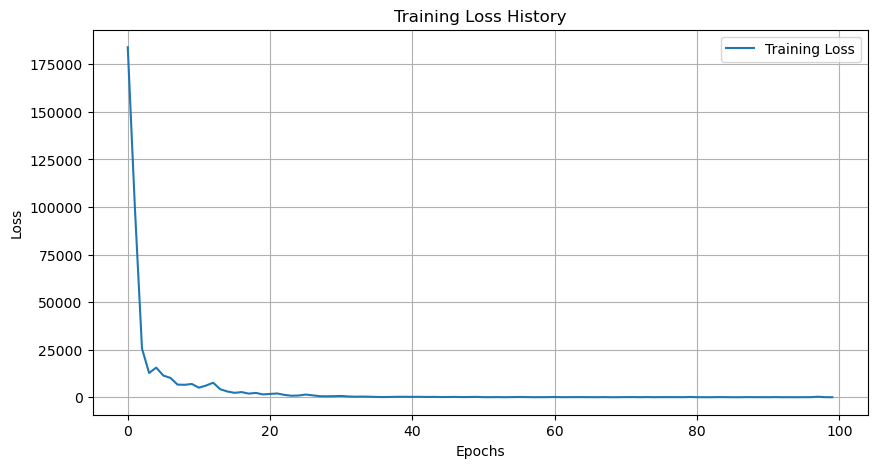

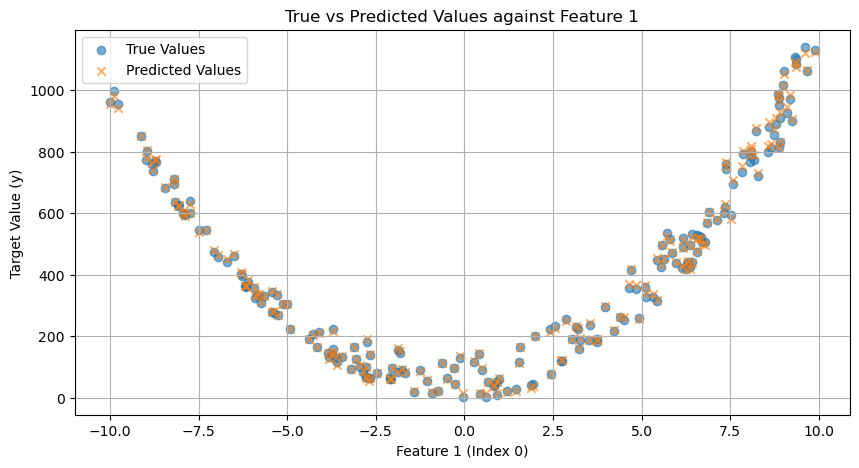

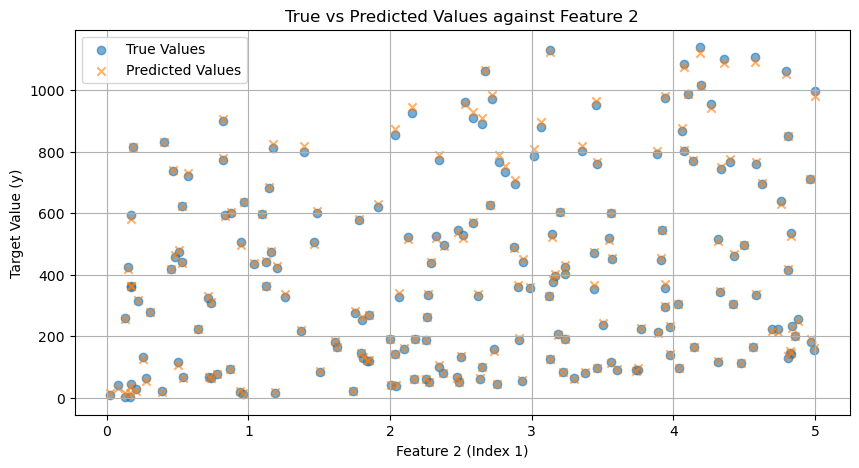

In [12]:
plot_regression_results(
    loss_history=model.training_history['train_loss_epoch'],
    X_test=data_module.X_test,
    y_test=data_module.y_test,
    y_test_pred=y_test_pred,
    feature_indices_to_plot=[0, 1] # Plot against first two features
)

## Conclusion 

In conclusion the above content aims to compare the implementation differences between Pytorch and Pytorch Lightning, where pytorch lightning enables researchers and machine learning engineers to train pytorch models at scale with no boiler plate code. Multiple Advantges that we will cover in later modules are: 

- Multi GPU training 
- checkpointing 
- Logging 
- Experiment Tracking and Evaluation. 
- Automatic Learning rates and batch size finders 
- Hyperparameter Tuning 
- Custom callbacks 
- Mixed Precision Training etc.

**Get Ready for the hands on project**

